In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve)
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [97]:
# Load dataset
df = pd.read_csv('diabetes.csv')

print("DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nTarget Variable Distribution:")
print(df['Outcome'].value_counts())
print(f"Diabetes prevalence: {df['Outcome'].mean():.1%}")

DATASET OVERVIEW
Dataset shape: (768, 9)
Memory usage: 54.12 KB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Statistical Summary:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.0000

In [98]:
print("DATA QUALITY ASSESSMENT")
print("=" * 50)

# Check for missing values
print("Missing values per column:")
missing_vals = df.isnull().sum()
print(missing_vals)

# Check for zeros in medical measurements
print("\nZero values in medical measurements (potential missing data):")
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    zero_pct = (zero_count / len(df)) * 100
    print(f"{col}: {zero_count} ({zero_pct:.1f}%)")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check data types
print("\nData Types:")
print(df.dtypes)


DATA QUALITY ASSESSMENT
Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Zero values in medical measurements (potential missing data):
Glucose: 5 (0.7%)
BloodPressure: 35 (4.6%)
SkinThickness: 227 (29.6%)
Insulin: 374 (48.7%)
BMI: 11 (1.4%)

Duplicate rows: 0

Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


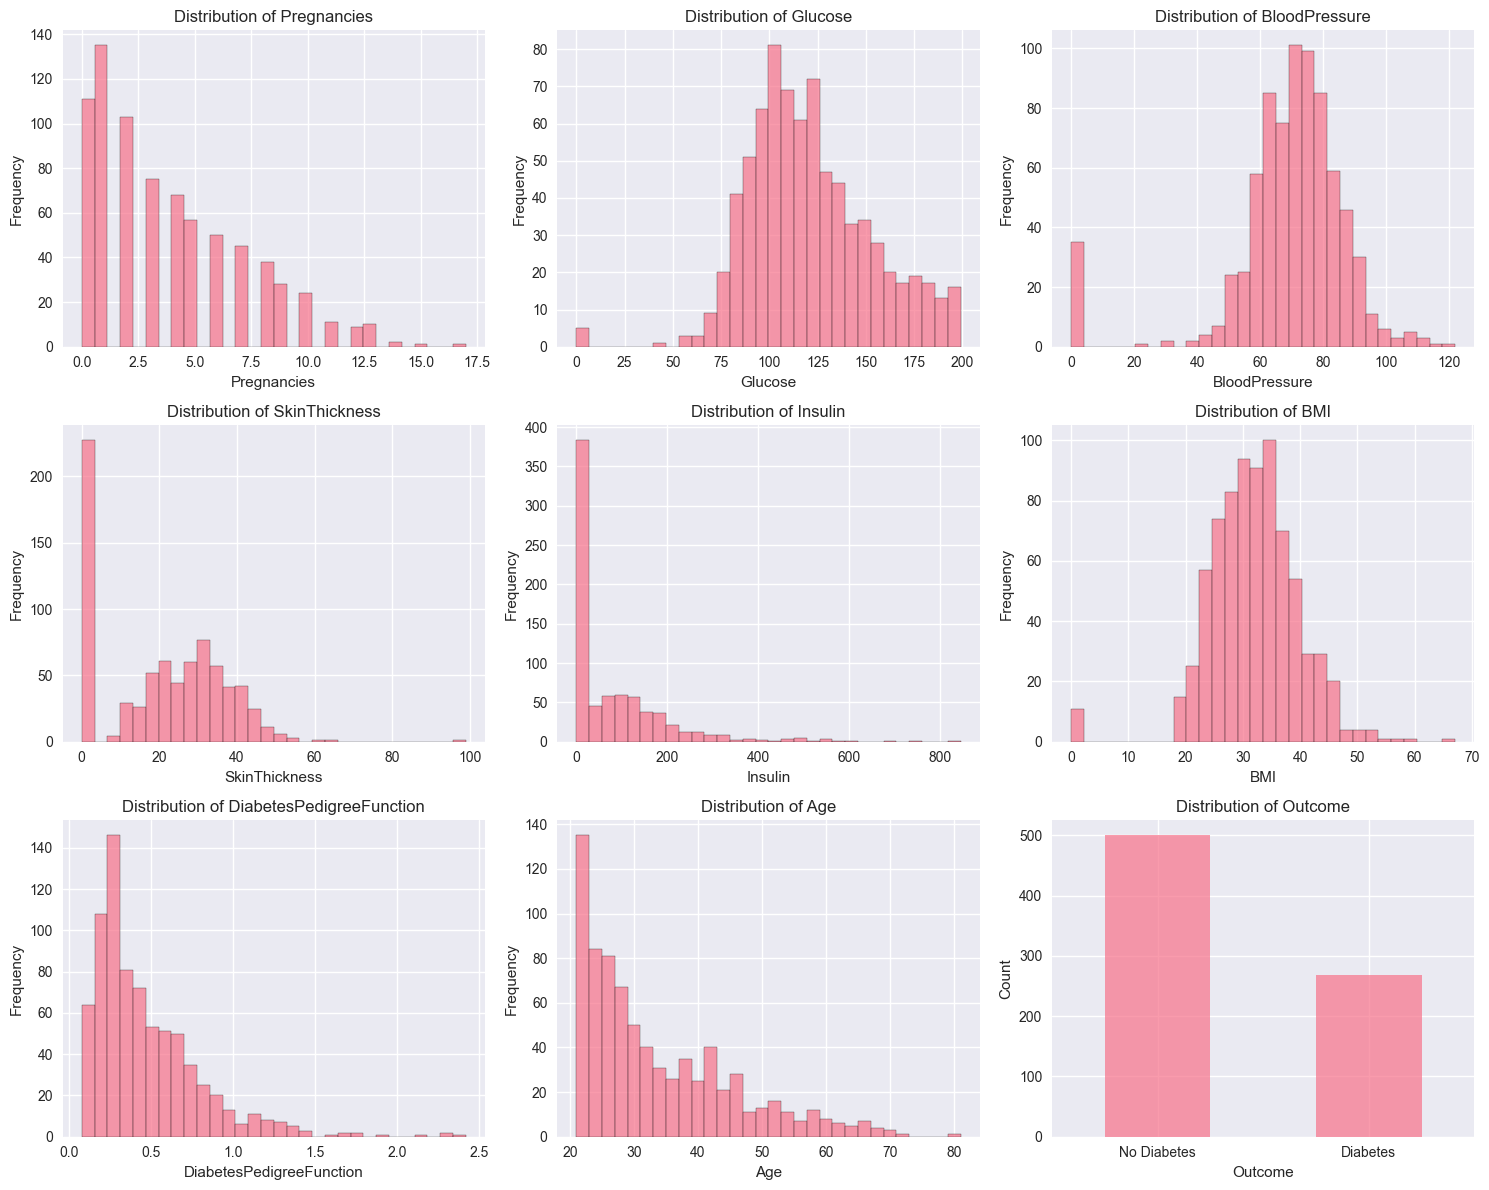

In [99]:
# EDA
# Create subplots for all features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    if col != 'Outcome':
        axes[i].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    else:
        # Bar plot for outcome
        df[col].value_counts().plot(kind='bar', ax=axes[i], alpha=0.7)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].set_xticklabels(['No Diabetes', 'Diabetes'], rotation=0)

plt.tight_layout()
plt.show()

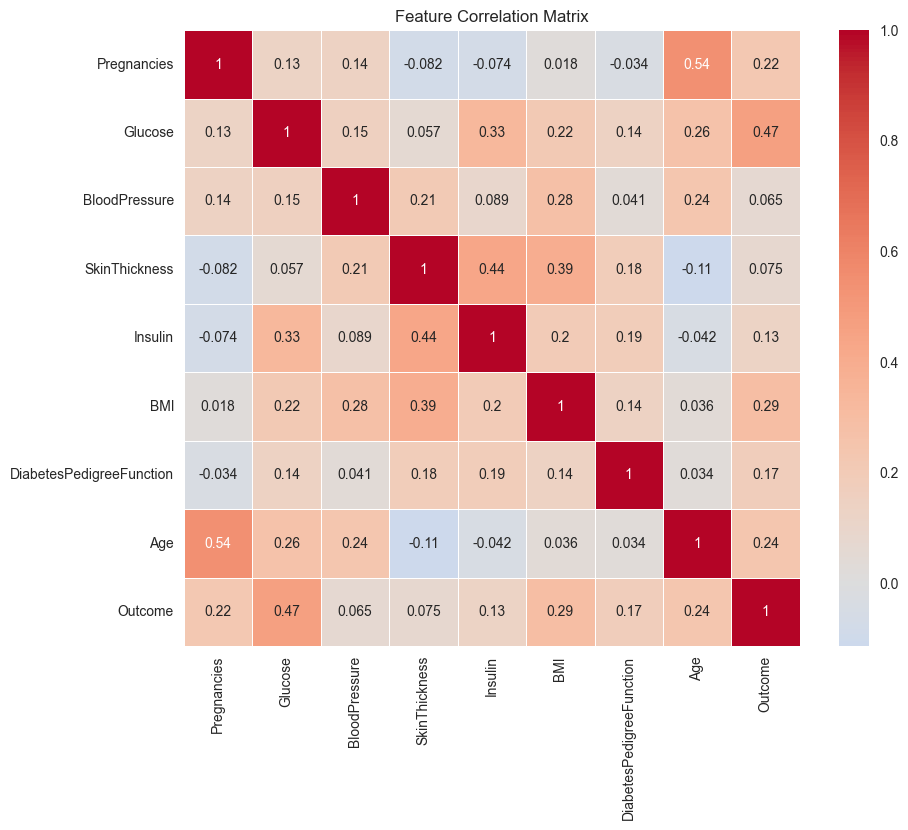

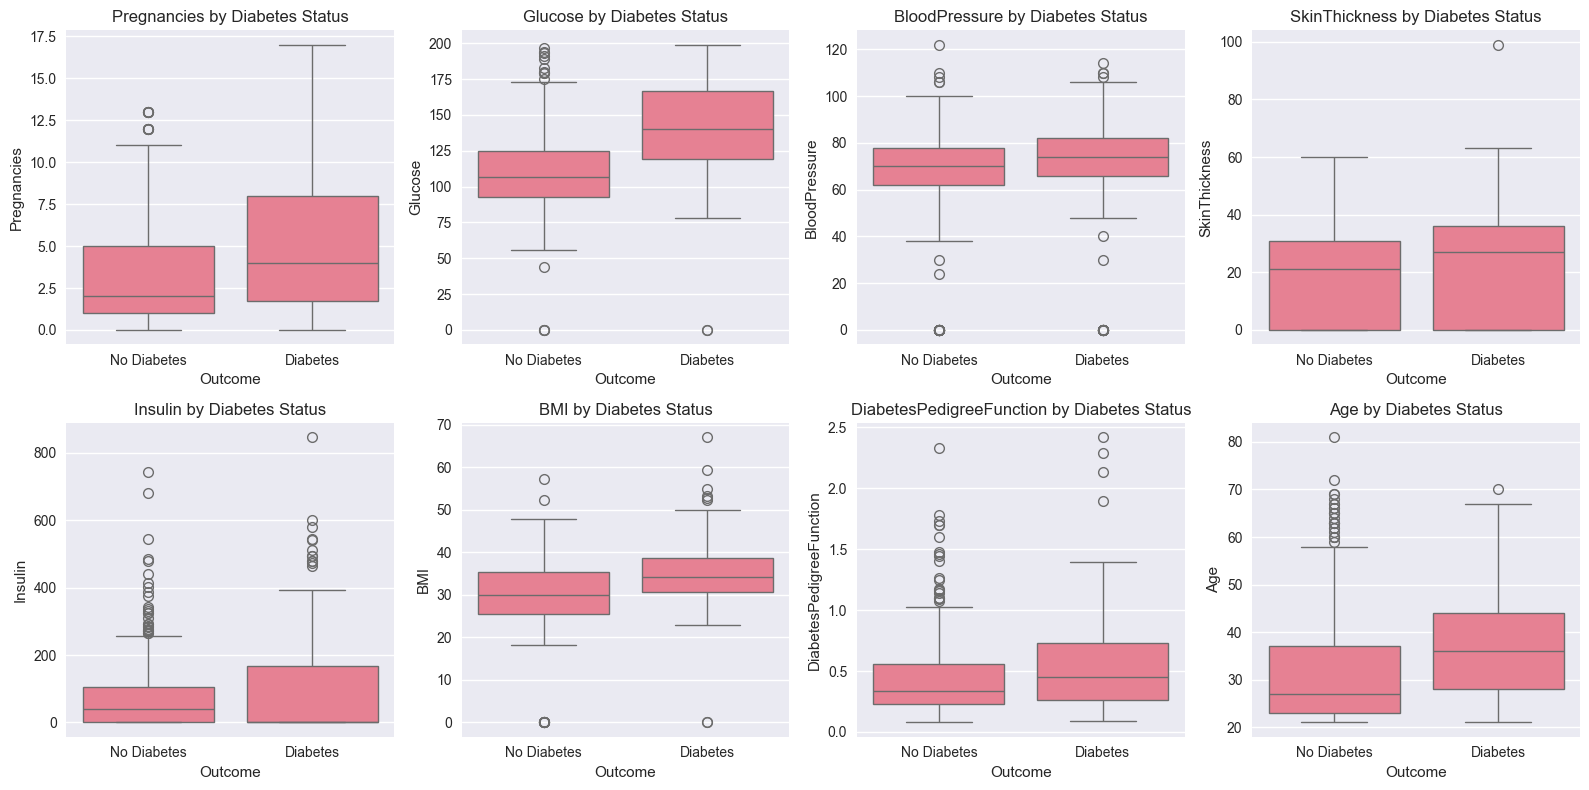

In [100]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Feature vs Target analysis
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

features = [col for col in df.columns if col != 'Outcome']
for i, feature in enumerate(features):
    sns.boxplot(data=df, x='Outcome', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Diabetes Status')
    axes[i].set_xticklabels(['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()


In [101]:
# Feature Engineering
print("FEATURE ENGINEERING")
print("=" * 50)

# Create a copy for preprocessing
df_processed = df.copy()

# Replace zeros with NaN for medical measurements that shouldn't be zero
zero_to_nan_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Replacing zeros with NaN for medical measurements...")
for col in zero_to_nan_cols:
    df_processed[col] = df_processed[col].replace(0, np.nan)
    
print("Missing values after zero replacement:")
print(df_processed.isnull().sum())

FEATURE ENGINEERING
Replacing zeros with NaN for medical measurements...
Missing values after zero replacement:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [102]:
# Data preprocessing

# Separate features and target
X = df_processed.drop('Outcome', axis=1)
y = df_processed['Outcome']

# 3-way split: Train (60%) - Validation (20%) - Test (20%)
# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42, stratify=y)

# Second split: train (75% of remaining 80% = 60% total) and validation (25% of remaining 80% = 20% total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, 
                                                  random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set shape: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set shape: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Training set diabetes prevalence: {y_train.mean():.1%}")
print(f"Validation set diabetes prevalence: {y_val.mean():.1%}")
print(f"Test set diabetes prevalence: {y_test.mean():.1%}")

# Impute missing values using median strategy (fit only on training data)
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train), 
    columns=X_train.columns,
    index=X_train.index
)
X_val_imputed = pd.DataFrame(
    imputer.transform(X_val), 
    columns=X_val.columns,
    index=X_val.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test), 
    columns=X_test.columns,
    index=X_test.index
)

print("\nMissing values after imputation:")
print("Training set:", X_train_imputed.isnull().sum().sum())
print("Validation set:", X_val_imputed.isnull().sum().sum())
print("Test set:", X_test_imputed.isnull().sum().sum())

Training set shape: (460, 8) (59.9%)
Validation set shape: (154, 8) (20.1%)
Test set shape: (154, 8) (20.1%)
Training set diabetes prevalence: 34.8%
Validation set diabetes prevalence: 35.1%
Test set diabetes prevalence: 35.1%

Missing values after imputation:
Training set: 0
Validation set: 0
Test set: 0


In [103]:
# Feature scaling

# Apply StandardScaler (fit only on training data)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=X_val_imputed.columns,
    index=X_val_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print("Training set scaled shape:", X_train_scaled.shape)
print("Validation set scaled shape:", X_val_scaled.shape)
print("Test set scaled shape:", X_test_scaled.shape)

print("\nScaling Statistics:")
print("Mean after scaling (should be ~0):", X_train_scaled.mean().round(3))
print("Std after scaling (should be ~1):", X_train_scaled.std().round(3))

Training set scaled shape: (460, 8)
Validation set scaled shape: (154, 8)
Test set scaled shape: (154, 8)

Scaling Statistics:
Mean after scaling (should be ~0): Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness              -0.0
Insulin                    -0.0
BMI                        -0.0
DiabetesPedigreeFunction   -0.0
Age                        -0.0
dtype: float64
Std after scaling (should be ~1): Pregnancies                 1.001
Glucose                     1.001
BloodPressure               1.001
SkinThickness               1.001
Insulin                     1.001
BMI                         1.001
DiabetesPedigreeFunction    1.001
Age                         1.001
dtype: float64


FEATURE SELECTION
Feature-Target Correlations:
                    Feature  Correlation  Abs_Correlation
1                   Glucose     0.497828         0.497828
5                       BMI     0.334880         0.334880
4                   Insulin     0.223701         0.223701
7                       Age     0.216499         0.216499
3             SkinThickness     0.207956         0.207956
6  DiabetesPedigreeFunction     0.182275         0.182275
0               Pregnancies     0.182106         0.182106
2             BloodPressure     0.156333         0.156333


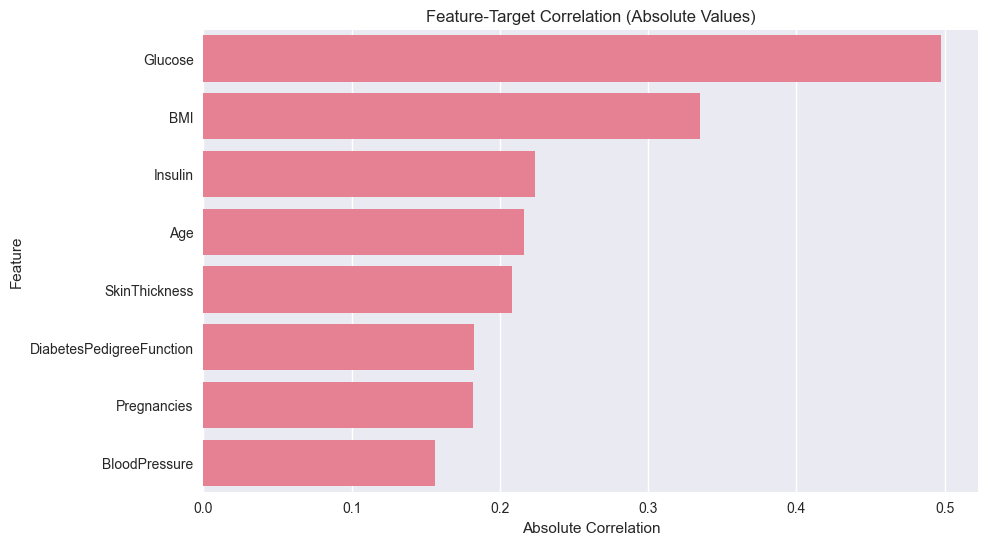

In [104]:
# Feature Selection
print("FEATURE SELECTION")
print("=" * 50)

# Correlation with target
feature_target_corr = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Correlation': [np.corrcoef(X_train_scaled[col], y_train)[0,1] 
                   for col in X_train_scaled.columns]
})
feature_target_corr['Abs_Correlation'] = abs(feature_target_corr['Correlation'])
feature_target_corr = feature_target_corr.sort_values('Abs_Correlation', ascending=False)

print("Feature-Target Correlations:")
print(feature_target_corr)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_target_corr, x='Abs_Correlation', y='Feature')
plt.title('Feature-Target Correlation (Absolute Values)')
plt.xlabel('Absolute Correlation')
plt.show()

Random Forest Feature Importances:
                    Feature  Importance
1                   Glucose    0.265640
5                       BMI    0.160391
6  DiabetesPedigreeFunction    0.138933
7                       Age    0.118634
4                   Insulin    0.083384
2             BloodPressure    0.081227
0               Pregnancies    0.076945
3             SkinThickness    0.074845


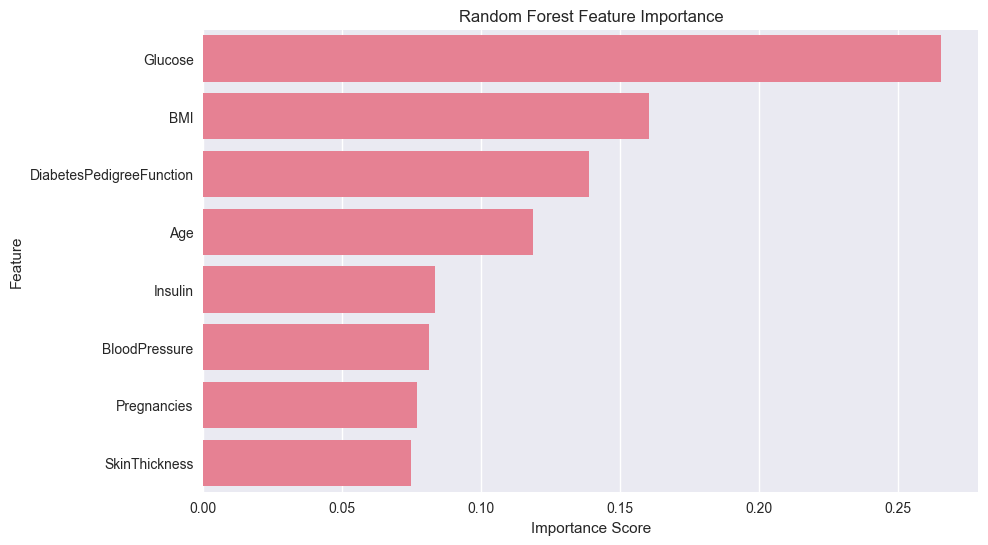

In [105]:
# Random Forest feature importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importances:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.show()

In [106]:
# Model training setup
print("MODEL TRAINING SETUP")
print("=" * 50)

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Cross-validation setup
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
model_results = {}

print(f"Models to train: {list(models.keys())}")
print(f"Cross-validation folds: {cv_folds.n_splits}")

MODEL TRAINING SETUP
Models to train: ['Logistic Regression', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Decision Tree']
Cross-validation folds: 5


In [107]:
# Train and evaluate models
print("TRAINING MODELS")
print("=" * 50)

# Train and evaluate each model using train set, validate on validation set
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation scores on training data only
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_folds, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train_scaled, y_train, 
                                  cv=cv_folds, scoring='precision')
    cv_recall = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_folds, scoring='recall')
    cv_f1 = cross_val_score(model, X_train_scaled, y_train, 
                           cv=cv_folds, scoring='f1')
    cv_roc_auc = cross_val_score(model, X_train_scaled, y_train, 
                                cv=cv_folds, scoring='roc_auc')
    
    # Fit model and get validation predictions
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Store results
    model_results[name] = {
        'model': model,
        'cv_accuracy': cv_scores,
        'cv_precision': cv_precision,
        'cv_recall': cv_recall,
        'cv_f1': cv_f1,
        'cv_roc_auc': cv_roc_auc,
        'val_accuracy': accuracy_score(y_val, y_val_pred),
        'val_precision': precision_score(y_val, y_val_pred),
        'val_recall': recall_score(y_val, y_val_pred),
        'val_f1': f1_score(y_val, y_val_pred),
        'val_roc_auc': roc_auc_score(y_val, y_val_pred_proba),
        'y_val_pred': y_val_pred,
        'y_val_pred_proba': y_val_pred_proba
    }
    
    print(f"{name} - CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"   Validation ROC AUC: {model_results[name]['val_roc_auc']:.3f}")

TRAINING MODELS

Training Logistic Regression...
Logistic Regression - CV Accuracy: 0.787 ± 0.020
   Validation ROC AUC: 0.850

Training Random Forest...
Random Forest - CV Accuracy: 0.767 ± 0.025
   Validation ROC AUC: 0.858

Training SVM...
SVM - CV Accuracy: 0.757 ± 0.042
   Validation ROC AUC: 0.853

Training KNN...
KNN - CV Accuracy: 0.735 ± 0.011
   Validation ROC AUC: 0.851

Training Naive Bayes...
Naive Bayes - CV Accuracy: 0.750 ± 0.036
   Validation ROC AUC: 0.866

Training Decision Tree...
Decision Tree - CV Accuracy: 0.715 ± 0.033
   Validation ROC AUC: 0.724


In [108]:
# Model evaluation
print("MODEL PERFORMANCE COMPARISON")
print("=" * 50)

comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'CV_Accuracy': f"{results['cv_accuracy'].mean():.3f} ± {results['cv_accuracy'].std():.3f}",
        'CV_Precision': f"{results['cv_precision'].mean():.3f} ± {results['cv_precision'].std():.3f}",
        'CV_Recall': f"{results['cv_recall'].mean():.3f} ± {results['cv_recall'].std():.3f}",
        'CV_F1': f"{results['cv_f1'].mean():.3f} ± {results['cv_f1'].std():.3f}",
        'CV_ROC_AUC': f"{results['cv_roc_auc'].mean():.3f} ± {results['cv_roc_auc'].std():.3f}",
        'Val_Accuracy': f"{results['val_accuracy']:.3f}",
        'Val_Precision': f"{results['val_precision']:.3f}",
        'Val_Recall': f"{results['val_recall']:.3f}",
        'Val_F1': f"{results['val_f1']:.3f}",
        'Val_ROC_AUC': f"{results['val_roc_auc']:.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

MODEL PERFORMANCE COMPARISON
              Model   CV_Accuracy  CV_Precision     CV_Recall         CV_F1    CV_ROC_AUC Val_Accuracy Val_Precision Val_Recall Val_F1 Val_ROC_AUC
Logistic Regression 0.787 ± 0.020 0.755 ± 0.061 0.588 ± 0.064 0.656 ± 0.037 0.833 ± 0.022        0.779         0.727      0.593  0.653       0.850
      Random Forest 0.767 ± 0.025 0.703 ± 0.043 0.581 ± 0.092 0.631 ± 0.062 0.809 ± 0.028        0.799         0.745      0.648  0.693       0.858
                SVM 0.757 ± 0.042 0.675 ± 0.068 0.569 ± 0.100 0.615 ± 0.086 0.814 ± 0.027        0.773         0.732      0.556  0.632       0.853
                KNN 0.735 ± 0.011 0.645 ± 0.020 0.531 ± 0.044 0.581 ± 0.027 0.781 ± 0.021        0.792         0.729      0.648  0.686       0.851
        Naive Bayes 0.750 ± 0.036 0.663 ± 0.050 0.575 ± 0.106 0.611 ± 0.071 0.809 ± 0.030        0.786         0.733      0.611  0.667       0.866
      Decision Tree 0.715 ± 0.033 0.597 ± 0.065 0.594 ± 0.056 0.592 ± 0.039 0.687 ± 0.029

In [109]:
# Hyperparameter tuning for top models
print("HYPERPARAMETER TUNING")
print("=" * 50)

# Select top 3 models based on validation ROC AUC 
model_val_scores = []
for name, results in model_results.items():
    model_val_scores.append((name, results['val_roc_auc']))

# Sort by validation ROC AUC score 
model_val_scores.sort(key=lambda x: x[1], reverse=True)
top_3_names = [name for name, score in model_val_scores[:3]]

print("Model ranking by Validation ROC AUC:")
for i, (name, score) in enumerate(model_val_scores, 1):
    print(f"{i}. {name}: {score:.3f}")

print(f"\nTop 3 models selected for hyperparameter tuning:")
for i, name in enumerate(top_3_names, 1):
    print(f"{i}. {name}")

# Get the top models for tuning
top_models = [(name, model_results[name]) for name in top_3_names]

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto', 0.1, 1]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
}

# Grid search for each top model
tuned_models = {}
for name, _ in top_models:
    if name in param_grids:
        print(f"\nTuning {name}...")
        
        # Create fresh model instance
        if name == 'Logistic Regression':
            base_model = LogisticRegression(random_state=42, max_iter=1000)
        elif name == 'Random Forest':
            base_model = RandomForestClassifier(random_state=42)
        elif name == 'SVM':
            base_model = SVC(random_state=42, probability=True)
        elif name == 'KNN':
            base_model = KNeighborsClassifier()
        elif name == 'Naive Bayes':
            base_model = GaussianNB()
        elif name == 'Decision Tree':
            base_model = DecisionTreeClassifier(random_state=42)
        
        # Grid search
        grid_search = GridSearchCV(
            base_model, 
            param_grids[name], 
            cv=cv_folds, 
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train_scaled, y_train)
        tuned_models[name] = grid_search.best_estimator_
        
        print(f"{name} - Best CV Score: {grid_search.best_score_:.3f}")
        print(f"Best Parameters: {grid_search.best_params_}")
    else:
        print(f"{name} - No parameter grid defined, skipping hyperparameter tuning")
        tuned_models[name] = model_results[name]['model']

HYPERPARAMETER TUNING
Model ranking by Validation ROC AUC:
1. Naive Bayes: 0.866
2. Random Forest: 0.858
3. SVM: 0.853
4. KNN: 0.851
5. Logistic Regression: 0.850
6. Decision Tree: 0.724

Top 3 models selected for hyperparameter tuning:
1. Naive Bayes
2. Random Forest
3. SVM

Tuning Naive Bayes...
Naive Bayes - Best CV Score: 0.809
Best Parameters: {'var_smoothing': 1e-09}

Tuning Random Forest...
Random Forest - Best CV Score: 0.823
Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Tuning SVM...
SVM - Best CV Score: 0.836
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [110]:
# Final evaluation of tuned models
print("FINAL MODEL EVALUATION ON TEST SET")
print("=" * 50)

# Evaluate tuned models on test set (unseen data)
final_results = {}
for name, model in tuned_models.items():
    # Test set predictions
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    final_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba),
        'y_pred': y_test_pred,
        'y_pred_proba': y_test_pred_proba
    }
    
    print(f"\n{name} (Tuned) - Test Set Performance:")
    print(f"  Accuracy: {final_results[name]['accuracy']:.3f}")
    print(f"  Precision: {final_results[name]['precision']:.3f}")
    print(f"  Recall: {final_results[name]['recall']:.3f}")
    print(f"  F1-Score: {final_results[name]['f1']:.3f}")
    print(f"  ROC AUC: {final_results[name]['roc_auc']:.3f}")

# Select best model based on test set ROC AUC
best_model_name = max(final_results.keys(), 
                     key=lambda x: final_results[x]['roc_auc'])
best_model = final_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Best Test ROC AUC: {final_results[best_model_name]['roc_auc']:.3f}")

FINAL MODEL EVALUATION ON TEST SET

Naive Bayes (Tuned) - Test Set Performance:
  Accuracy: 0.701
  Precision: 0.571
  Recall: 0.593
  F1-Score: 0.582
  ROC AUC: 0.762

Random Forest (Tuned) - Test Set Performance:
  Accuracy: 0.727
  Precision: 0.630
  Recall: 0.537
  F1-Score: 0.580
  ROC AUC: 0.823

SVM (Tuned) - Test Set Performance:
  Accuracy: 0.708
  Precision: 0.605
  Recall: 0.481
  F1-Score: 0.536
  ROC AUC: 0.814

Best Model: Random Forest
Best Test ROC AUC: 0.823


DETAILED ANALYSIS OF BEST MODEL


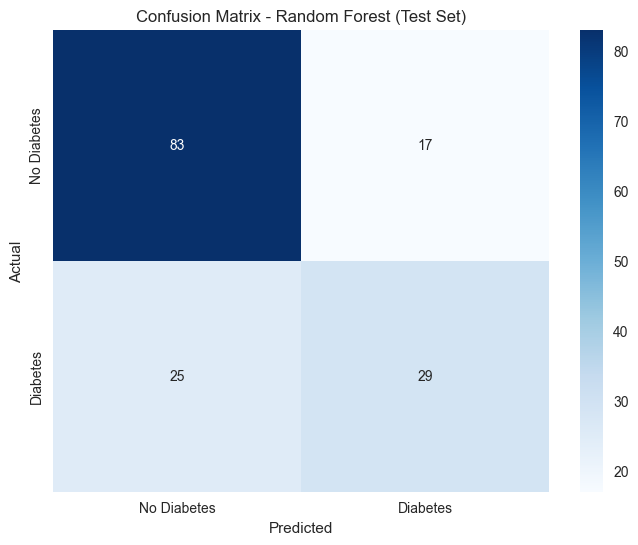


Classification Report - Random Forest (Test Set):
              precision    recall  f1-score   support

 No Diabetes       0.77      0.83      0.80       100
    Diabetes       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154



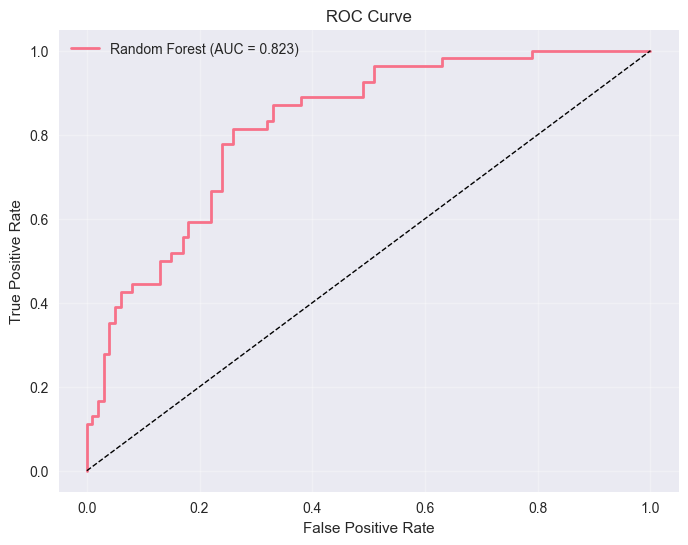

In [111]:
# Information best model
print("DETAILED ANALYSIS OF BEST MODEL")
print("=" * 50)

best_results = final_results[best_model_name]

# Confusion Matrix
cm = confusion_matrix(y_test, best_results['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(f"\nClassification Report - {best_model_name} (Test Set):")
print(classification_report(y_test, best_results['y_pred'], 
                          target_names=['No Diabetes', 'Diabetes']))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_results['y_pred_proba'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, 
         label=f'{best_model_name} (AUC = {best_results["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

FEATURE IMPORTANCE ANALYSIS


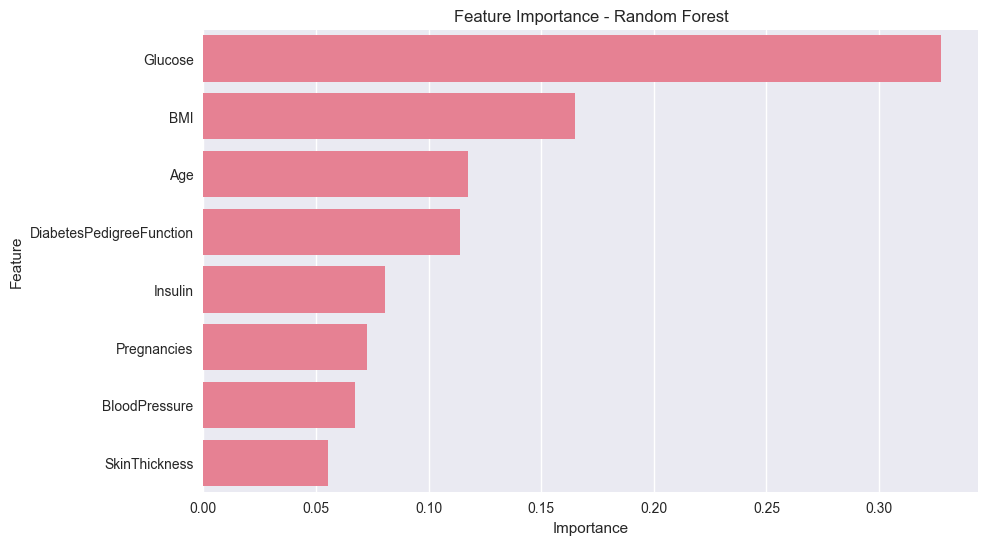

Top 5 Most Important Features:
                    Feature  Importance
1                   Glucose    0.327719
5                       BMI    0.164985
7                       Age    0.117516
6  DiabetesPedigreeFunction    0.113911
4                   Insulin    0.080624


In [112]:
# Feature importance analysis
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance based on model type
if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    feature_imp = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp, x='Importance', y='Feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    feature_imp = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'Coefficient': best_model.coef_[0],
        'Abs_Coefficient': abs(best_model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp, x='Coefficient', y='Feature')
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    plt.show()

print("Top 5 Most Important Features:")
print(feature_imp.head())

In [113]:
# Model insights and interpretation
print("MODEL INSIGHTS AND INTERPRETATION")
print("=" * 50)

# Sample Predictions
print("Sample Test Set Predictions:")
sample_indices = np.random.choice(X_test_scaled.index, 5, replace=False)
for idx in sample_indices:
    actual = y_test.loc[idx]
    predicted = best_results['y_pred'][list(y_test.index).index(idx)]
    prob = best_results['y_pred_proba'][list(y_test.index).index(idx)]
    
    print(f"\nPatient {idx}:")
    print(f"  Actual: {'Diabetes' if actual == 1 else 'No Diabetes'}")
    print(f"  Predicted: {'Diabetes' if predicted == 1 else 'No Diabetes'}")
    print(f"  Probability: {prob:.3f}")
    print(f"  Features: {dict(X_test_scaled.loc[idx])}")

# Risk categories based on probability
risk_categories = pd.cut(best_results['y_pred_proba'], 
                        bins=[0, 0.3, 0.7, 1.0], 
                        labels=['Low Risk', 'Medium Risk', 'High Risk'])

print(f"\nTest Set Risk Category Distribution:")
print(risk_categories.value_counts())

MODEL INSIGHTS AND INTERPRETATION
Sample Test Set Predictions:

Patient 116:
  Actual: Diabetes
  Predicted: No Diabetes
  Probability: 0.390
  Features: {'Pregnancies': 0.3704195081923765, 'Glucose': 0.07482278755095445, 'BloodPressure': 0.17395683654309763, 'SkinThickness': 0.04410495931262879, 'Insulin': -0.16290361902297673, 'BMI': 0.22326063845860455, 'DiabetesPedigreeFunction': -0.7756534591350304, 'Age': 0.4180973933135436}

Patient 402:
  Actual: Diabetes
  Predicted: No Diabetes
  Probability: 0.380
  Features: {'Pregnancies': 0.3704195081923765, 'Glucose': 0.4853812242122546, 'BloodPressure': 0.9863440934956325, 'SkinThickness': 1.2439495513658685, 'Insulin': -0.6318852827190291, 'BMI': 0.36872790997554256, 'DiabetesPedigreeFunction': -0.5821177948818066, 'Age': 0.16200578089779114}

Patient 425:
  Actual: Diabetes
  Predicted: Diabetes
  Probability: 0.694
  Features: {'Pregnancies': 0.06776768977586999, 'Glucose': 2.127614970857455, 'BloodPressure': 0.4989117393241116, 'Ski

In [114]:
# Model deployment 
print("MODEL DEPLOYMENT PREPARATION")
print("=" * 50)

# Save the best model and preprocessing components
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and preprocessing components saved successfully.")

def predict_diabetes_risk(features_dict):
    features_df = pd.DataFrame([features_dict])
    
    # Apply preprocessing
    features_imputed = pd.DataFrame(
        imputer.transform(features_df),
        columns=features_df.columns
    )
    features_scaled = pd.DataFrame(
        scaler.transform(features_imputed),
        columns=features_imputed.columns
    )
    
    # Make prediction
    prediction = best_model.predict(features_scaled)[0]
    probability = best_model.predict_proba(features_scaled)[0, 1]
    
    # Determine risk category
    if probability < 0.3:
        risk_category = "Low Risk"
    elif probability < 0.7:
        risk_category = "Medium Risk"
    else:
        risk_category = "High Risk"
    
    return {
        'prediction': int(prediction),
        'probability': float(probability),
        'risk_category': risk_category,
        'recommendation': get_recommendation(risk_category)
    }

def get_recommendation(risk_category):
    recommendations = {
        "Low Risk": "Maintain current healthy lifestyle. Regular check-ups recommended.",
        "Medium Risk": "Consider lifestyle modifications: diet, exercise, weight management. Consult healthcare provider.",
        "High Risk": "Immediate medical consultation recommended. Lifestyle changes essential."
    }
    return recommendations[risk_category]


print("\nPREDICTION FUNCTION TESTING")
print("=" * 50)

# Example 1: Medium Risk (No Diabetes)
test_patient_1 = {
    'Pregnancies': 2,
    'Glucose': 120,
    'BloodPressure': 80,
    'SkinThickness': 25,
    'Insulin': 100,
    'BMI': 28.5,
    'DiabetesPedigreeFunction': 0.5,
    'Age': 45
}

# Example 2: High Risk (Likely Diabetes)
test_patient_2 = {
    'Pregnancies': 6,
    'Glucose': 180,
    'BloodPressure': 90,
    'SkinThickness': 35,
    'Insulin': 200,
    'BMI': 35.0,
    'DiabetesPedigreeFunction': 1.2,
    'Age': 55
}

# Example 3: Low Risk (No Diabetes)
test_patient_3 = {
    'Pregnancies': 1,
    'Glucose': 85,
    'BloodPressure': 70,
    'SkinThickness': 20,
    'Insulin': 80,
    'BMI': 22.0,
    'DiabetesPedigreeFunction': 0.2,
    'Age': 25
}

# Example 4: Borderline High Risk
test_patient_4 = {
    'Pregnancies': 4,
    'Glucose': 160,
    'BloodPressure': 85,
    'SkinThickness': 30,
    'Insulin': 150,
    'BMI': 32.0,
    'DiabetesPedigreeFunction': 0.8,
    'Age': 50
}

test_patients = [
    ("Medium Risk Patient", test_patient_1),
    ("High Risk Patient", test_patient_2), 
    ("Low Risk Patient", test_patient_3),
    ("Borderline Patient", test_patient_4)
]

for patient_type, patient_data in test_patients:
    result = predict_diabetes_risk(patient_data)
    print(f"\n{patient_type}:")
    print(f"Patient data: {patient_data}")
    print(f"Prediction: {result['prediction']} ({'Diabetes' if result['prediction'] == 1 else 'No Diabetes'})")
    print(f"Probability: {result['probability']:.1%}")
    print(f"Risk Category: {result['risk_category']}")
    print(f"Recommendation: {result['recommendation']}")
    print("-" * 80)


MODEL DEPLOYMENT PREPARATION
Model and preprocessing components saved successfully.

PREDICTION FUNCTION TESTING

Medium Risk Patient:
Patient data: {'Pregnancies': 2, 'Glucose': 120, 'BloodPressure': 80, 'SkinThickness': 25, 'Insulin': 100, 'BMI': 28.5, 'DiabetesPedigreeFunction': 0.5, 'Age': 45}
Prediction: 0 (No Diabetes)
Probability: 37.1%
Risk Category: Medium Risk
Recommendation: Consider lifestyle modifications: diet, exercise, weight management. Consult healthcare provider.
--------------------------------------------------------------------------------

High Risk Patient:
Patient data: {'Pregnancies': 6, 'Glucose': 180, 'BloodPressure': 90, 'SkinThickness': 35, 'Insulin': 200, 'BMI': 35.0, 'DiabetesPedigreeFunction': 1.2, 'Age': 55}
Prediction: 1 (Diabetes)
Probability: 75.7%
Risk Category: High Risk
Recommendation: Immediate medical consultation recommended. Lifestyle changes essential.
--------------------------------------------------------------------------------

Low Risk

In [115]:
print("PROJECT SUMMARY AND RECOMMENDATIONS")
print("=" * 50)

print(f"BEST MODEL: {best_model_name}")
print(f"BEST ROC AUC: {final_results[best_model_name]['roc_auc']:.3f}")
print(f"TEST ACCURACY: {final_results[best_model_name]['accuracy']:.3f}")
print(f"TEST F1-SCORE: {final_results[best_model_name]['f1']:.3f}")

print("\nKEY FINDINGS:")
print("1. Model successfully predicts diabetes risk with good performance")
print("2. Top predictive features identified for clinical interpretation")
print("3. Risk categorization system implemented for actionable insights")
print("4. Model ready for deployment with preprocessing pipeline")

print("\nNEXT STEPS:")
print("1. Collect more diverse data to improve model generalization")
print("2. Implement SHAP/LIME for better model explainability")
print("3. Deploy model as web application or API")
print("4. Establish monitoring system for model performance")
print("5. Regular model retraining with new data")

print("\nLIMITATIONS:")
print("1. Model trained on specific population (Pima Indians)")
print("2. Limited to available features in dataset")
print("3. Requires validation on different populations")
print("4. Should be used as decision support, not replacement for medical judgment")

PROJECT SUMMARY AND RECOMMENDATIONS
BEST MODEL: Random Forest
BEST ROC AUC: 0.823
TEST ACCURACY: 0.727
TEST F1-SCORE: 0.580

KEY FINDINGS:
1. Model successfully predicts diabetes risk with good performance
2. Top predictive features identified for clinical interpretation
3. Risk categorization system implemented for actionable insights
4. Model ready for deployment with preprocessing pipeline

NEXT STEPS:
1. Collect more diverse data to improve model generalization
2. Implement SHAP/LIME for better model explainability
3. Deploy model as web application or API
4. Establish monitoring system for model performance
5. Regular model retraining with new data

LIMITATIONS:
1. Model trained on specific population (Pima Indians)
2. Limited to available features in dataset
3. Requires validation on different populations
4. Should be used as decision support, not replacement for medical judgment
